In [1]:
from PIL import Image
import os
from sklearn.cluster import KMeans
from skimage import measure
from skimage.transform import resize
import pydicom
import csv
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage
import SimpleITK as sitk
import numpy as np
import skimage as sk
import skimage.morphology as morph
from scipy import ndimage

In [2]:

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morph.erosion(thresh_img,np.ones([3,3]))
    dilation = morph.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morph.dilation(mask,np.ones([10,10])) # one last dilation

    """if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()"""
    return mask*img

In [3]:
def resample(image,dicom_file,new_spacing=[1,1]):
    # Determine current pixel spacing
    SliceThickness = dicom_file.SliceThickness
    PixelSpacing=dicom_file.PixelSpacing
    
   
    
    spacing = map(float, (list(PixelSpacing)))
    spacing = np.array(list(spacing))
    
    resize_factor = spacing / new_spacing
    
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image


In [4]:
import xml.etree.ElementTree as ET
def read_xml_file(filepath):
     
    it = ET.iterparse(filepath)
    for _, el in it:
        if '}' in el.tag:
            el.tag = el.tag.split('}', 1)[1]  # strip all namespaces
        for at in el.attrib.keys(): # strip namespaces of attributes too
            if '}' in at:
                newat = at.split('}', 1)[1]
                el.attrib[newat] = el.attrib[at]
                del el.attrib[at]
    return it.root
def get_study_uid(root):
    result=None
    try:
        result=root.find("ResponseHeader/StudyInstanceUID").text
    except:
        pass
    return result

def get_series_uid(root):
    result=None
    try:
        result=root.find("ResponseHeader/SeriesInstanceUid").text
    except:
        pass
    return result

def get_details(xml,SOPInstanceUID):
    type_,roi_pre,x_coord,y_coord,imageZposition,malignancy=None,1,512,512,-999,None
    """print ("idhar")"""
    LidcReadMessage = xml.find("ResponseHeader") 
    
    for reading_session in xml.iter("readingSession"):
        # print("Sesion")
        #nodules = reading_session.find_all("unblindedReadNodule")
        for nodule in reading_session.iter("unblindedReadNodule"):
            
            # print("  ", nodule.noduleID)
            #rois = nodule.find_all("roi")
            x_min = y_min = 1024
            x_max = y_max =-1024
            

            for roi in nodule.iter("roi"):
                
                if str(roi.find("imageSOP_UID").text) == SOPInstanceUID : 
                    type_="Nodule"
                    """print (roi.find("imageZposition").text)
                    """
                    imageZposition = float(roi.find("imageZposition").text)
                    
                    edge_maps = roi.findall("edgeMap")
                    for edge_map in edge_maps:
                        x = int(edge_map.find("xCoord").text)
                        y = int(edge_map.find("yCoord").text)
                        x_min = min(x_min, x)
                        y_min = min(y_min, y)
                        x_max = max(x_max, x)
                        y_max = max(y_max, y)
                    if x_max == x_min:
                        continue
                    if y_max == y_min:
                        continue
                    x_coord = (x_min+x_max)/2
                    y_coord = (y_min+y_max)/2
                   
                  
                    """plt.imshow(ds1.pixel_array[int(y_center-16):int(y_center+16), int(x_center-16):int(x_center+16)])
                    plt.show()
                    print (ds1.pixel_array[int(y_center-16):int(y_center+16), int(x_center-16):int(x_center+16)])
                    print (ds1.pixel_array[int(y_center-16):int(y_center+16), int(x_center-16):int(x_center+16)].shape)
                    """
                    if nodule.find("characteristics") is None:
                        print("!!!!Nodule:", nodule_id, " has no charecteristics")
                        continue
                        
                    """if nodule.find("characteristics").find("malignancy").text is None:
                        print("!!!!Nodule:", nodule_id, " has no malignacy")
                        continue
                   """
                    malignancy=int(nodule.find(".//characteristics/malignancy").text) 

                    
                    
        nonNodules = reading_session.findall("nonNodule")
        for nonNodule in nonNodules:
            if str(nonNodule.find("imageSOP_UID").text) == SOPInstanceUID :
                x_coord = int(nonNodule.find("locus").find("xCoord").text)
                y_coord = int(nonNodule.find("locus").find("yCoord").text)
                
                malignancy = -1
                type_="Non-Nodule"
                imageZposition = float(nonNodule.find("imageZposition").text)
    
    return list((type_,imageZposition,roi_pre,x_coord,y_coord,malignancy))
                



In [5]:
def call_get_details(xml_tree,SOPInstanceUID):
    res=[]
    
    res = get_details(xml_tree,str(SOPInstanceUID))
    #print (res)
    if res[0] == None :
        return None
    else:
        if res[0] == "Nodule" :
            if res[-1] >= 3 :
                res.append(1)
            else:
                res.append(2)
        else:
            res.append(3)
        return res    



    return None     

In [12]:
def find_xml_file(directory,SeriesInstanceUID,StudyInstanceUID):
    
    for filename in os.listdir(os.path.join(directory,fp)):
        if filename.endswith(".xml"):

            xml=read_xml_file(os.path.join(directory,fp,filename))
            if (get_series_uid(xml) == str(SeriesInstanceUID) and get_study_uid(xml) == str(StudyInstanceUID)):
                return xml





        else:
            continue
    return None     

In [13]:
def pre_process_img(ds1):
    lung_image = ds1.pixel_array*ds1.RescaleSlope+ds1.RescaleIntercept
    resample_image = resample(lung_image,ds1)
    final_image = make_lungmask(resample_image)
    
    return final_image
    
    

In [16]:
directory = "B:\mini_project"
columns_of_csv = ['img_filename','Patient ID','Series Instance UID','Study Instance ID',"Image_SOP_UID","type","ImageZPosition","roi","x-coord","y-coord","malignancy","cancer"]
filename_csv = "meta_data_final.csv"

with open(filename_csv, 'w') as csvfile:  
    csvwriter = csv.writer(csvfile)  
        
    csvwriter.writerow(columns_of_csv)  
    
dcm_file=os.path.join(directory,"LIDC-IDRI")
img_path=os.listdir(directory)
jpg_folder_1=directory+"images_folder_1"
jpg_folder_2=directory+"images_folder_2"
jpg_folder_3=directory+"images_folder_3"

for fp in os.listdir(dcm_file):
    row=[]
    xml_tree=None
    count=0
    for filename in os.listdir(dcm_file+"/"+fp):
        
        if filename.endswith(".dcm"):
            print (os.path.join(dcm_file,fp,filename))
            
            dcm_name = os.path.join(dcm_file,fp,filename)
            ds = pydicom.filereader.dcmread(dcm_name)
            if count == 0:
                count+=1
                xml_tree = find_xml_file(os.path.join(dcm_file,fp),ds.SeriesInstanceUID,ds.StudyInstanceUID)
            if xml_tree == None :
                continue
            result= call_get_details(xml_tree,ds.SOPInstanceUID)
            if (result != None):
                ds_1=pydicom.dcmread(dcm_name)
                

                filename=filename.replace('.dcm','.jpg')
                tmp=ds.PatientID + "_" + filename
                if (result[-1] == 1):
                    jpg_folder=jpg_folder_1
                elif (result[-1] == 2 ):
                    jpg_folder=jpg_folder_2
                else :
                    jpg_folder = jpg_folder_3
                final_image = pre_process_img(ds_1)
                result_image = Image.fromarray((final_image * 255).astype(np.uint8))
                
                tmp = str(os.path.join(jpg_folder,tmp))
                result_image.save(tmp)
                row.append(list((tmp,ds.PatientID,ds.SeriesInstanceUID,ds.StudyInstanceUID,ds.SOPInstanceUID))+result)
            

            continue
        else:
            continue
    # writing to csv file  
    with open(filename_csv, 'a') as csvfile:  
        csvwriter = csv.writer(csvfile)  

        csvwriter.writerows(row)
    
    print ("*"*20,"Done Completed Folder",dcm_file+"/"+fp,"*"*20)    

print ("*"*20,"Done Completed","*"*20)    

B:\mini_project\LIDC-IDRI\LIDC-IDRI-0001\000001.dcm


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'B:\\mini_project\tcia-lidc-xml'

In [7]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [67]:
lung_image = window_image(hu_img, -600, 1600)

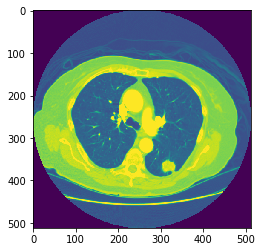

In [68]:
plt.imshow(lung_image)

In [26]:
def remove_noise(medical_image, display=False):
    image = medical_image.pixel_array
    
    brain_image=image*medical_image.RescaleSlope+medical_image.RescaleIntercept
    
    #brain_image = window_image(hu_image, medical_image.WindowCenter,medical_image.WindowWidth)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morph.dilation(brain_image, np.ones((5, 5)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morph.dilation(mask, np.ones((5, 5)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morph.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    plt.imshow(masked_image)
    
    return masked_image

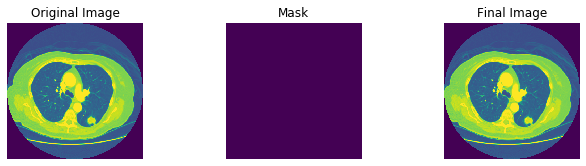

In [76]:
img_1 = remove_noise(lung,True)

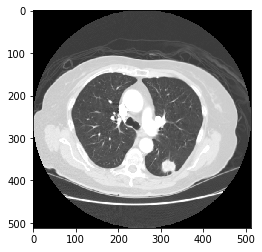

In [64]:
plt.imshow(img_1,cmap="gray")

In [59]:
image_12 = cv2.rectangle(img_1,(286,340),(340,390),(255, 0, 0),5)

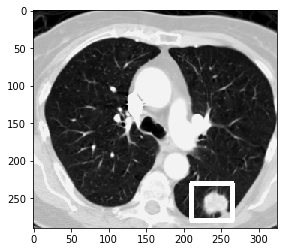

In [61]:
plt.imshow(image_12[110:400,75:400],cmap="gray")

In [77]:
import scipy.ndimage

In [117]:
img_23,new_spacing = resample(img_1,ds1)

[0.703125 0.703125]
[0.703125 0.703125]      [0.703125 0.703125]


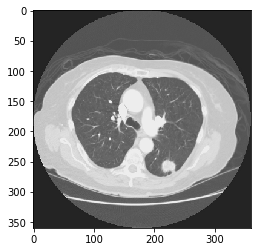

In [118]:
plt.imshow(img_23,cmap="gray")

In [119]:
img_23.shape

(360, 360)

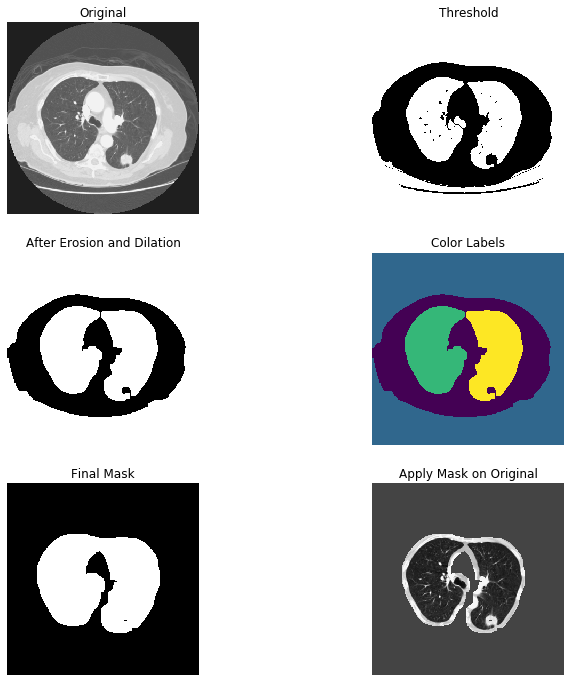

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [121]:
make_lungmask(img_23,True)